In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)


df = pd.read_csv("../data/processed/cleaned_readmission.csv")
target = "readmitted_30"
y = df[target]
X = df.drop(columns=[target])
print(X.shape, y.shape)


def eval_model(model, X_train, y_train, X_val, y_val, name="model", return_metrics=False):
    """
    Comprehensive model evaluation function that returns multiple metrics.
    
    Returns:
        dict: Dictionary containing y_prob, y_pred, and all metrics if return_metrics=True
        array: y_prob if return_metrics=False (for backward compatibility)
    """
    model.fit(X_train, y_train)
    
    print(f"\n=== {name}: TRAIN ===")
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train, y_train_pred))
    
    print(f"=== {name}: VAL ===")
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val, y_val_pred))
    
    results = {'name': name, 'y_pred': y_val_pred}
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val)[:, 1]
        results['y_prob'] = y_prob
        
        # Calculate comprehensive metrics
        roc_auc = roc_auc_score(y_val, y_prob)
        pr_auc = average_precision_score(y_val, y_prob)
        f1 = f1_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        
        print(f"{name} ROC-AUC: {roc_auc:.4f}")
        print(f"{name} PR-AUC (Average Precision): {pr_auc:.4f}")
        print(f"{name} F1-Score: {f1:.4f}")
        
        results.update({
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
        
        if return_metrics:
            return results
        return y_prob
    
    if return_metrics:
        return results
    return None

(101766, 43) (101766,)


In [82]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

In [84]:
log_reg.fit(X_train, y_train)

y_val_pred = log_reg.predict(X_val)
y_val_prob = log_reg.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("PR-AUC (Average Precision):", average_precision_score(y_val, y_val_prob))

# Threshold analysis
y_val_pred_03 = (y_val_prob >= 0.3).astype(int)
print("\n=== Threshold = 0.3 ===")
print(classification_report(y_val, y_val_pred_03))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     13561
           1       0.17      0.54      0.26      1704

    accuracy                           0.65     15265
   macro avg       0.54      0.60      0.52     15265
weighted avg       0.84      0.65      0.72     15265

ROC-AUC: 0.6468344392733512
PR-AUC (Average Precision): 0.1989255439867688

=== Threshold = 0.3 ===
              precision    recall  f1-score   support

           0       0.95      0.04      0.07     13561
           1       0.11      0.98      0.20      1704

    accuracy                           0.14     15265
   macro avg       0.53      0.51      0.14     15265
weighted avg       0.86      0.14      0.09     15265



### Threshold Selection and Tradeoffs

The logistic regression model outputs a probability representing the estimated risk of 30-day readmission. A decision threshold is then applied to convert this probability into a binary prediction.

Using the default threshold of 0.5 results in moderate recall, as the model only flags patients it is highly confident will be readmitted. Lowering the threshold makes the model more aggressive, increasing recall by identifying a larger proportion of high-risk patients, but at the cost of reduced precision due to more false positives.

In this clinical context, prioritizing recall is appropriate, as failing to identify a high-risk patient (false negative) is more costly than flagging additional patients for further review.


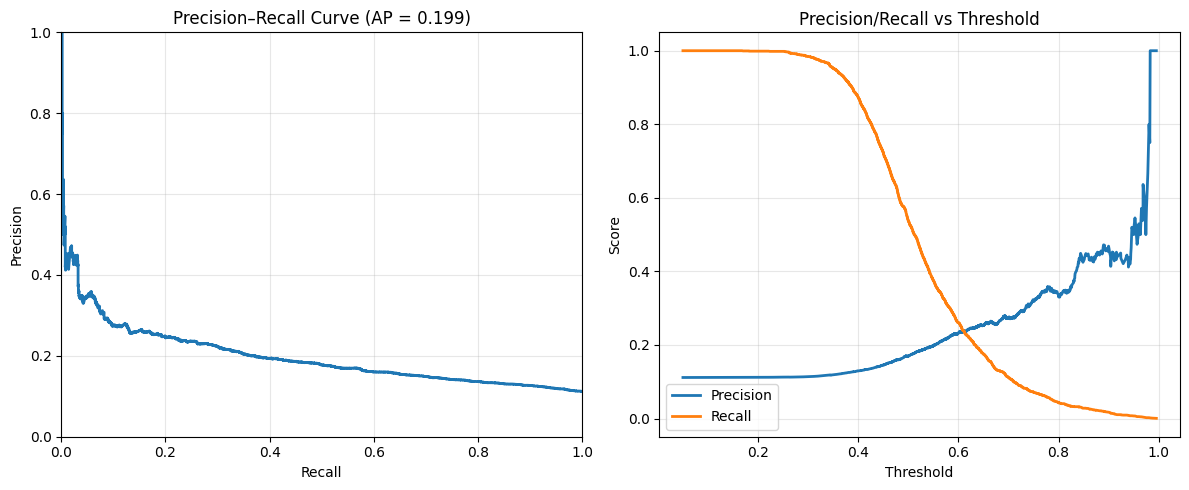

In [85]:
prec, rec, thresh = precision_recall_curve(y_val, y_val_prob)
ap = average_precision_score(y_val, y_val_prob)

# Precision-Recall Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)

# Precision/Recall vs Threshold
plt.subplot(1, 2, 2)
plt.plot(thresh, prec[:-1], label="Precision", linewidth=2)
plt.plot(thresh, rec[:-1], label="Recall", linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()



Lowering the decision threshold increases recall by identifying a larger proportion of high-risk patients, but this comes at the cost of reduced precision due to a higher number of false positives.

### Tree Model
While adjusting the decision threshold allows recall to be increased, the resulting drop in precision highlights the limitations of a linear model in capturing complex interactions within the data, motivating the exploration of non-linear, tree-based models.


In [86]:
from sklearn.tree import DecisionTreeClassifier

#we are not restricting the max_depth on purpose for testing later
tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(
        max_depth=None,
        class_weight="balanced",
        random_state=42
    ))
])

tree.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [87]:
from sklearn.metrics import classification_report

print("TRAIN PERFORMANCE")
print(classification_report(y_train, tree.predict(X_train)))

print("\nVALIDATION PERFORMANCE")
print(classification_report(y_val, tree.predict(X_val)))

TRAIN PERFORMANCE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63286
           1       1.00      1.00      1.00      7950

    accuracy                           1.00     71236
   macro avg       1.00      1.00      1.00     71236
weighted avg       1.00      1.00      1.00     71236


VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     13561
           1       0.16      0.17      0.17      1704

    accuracy                           0.81     15265
   macro avg       0.53      0.53      0.53     15265
weighted avg       0.81      0.81      0.81     15265



### Decision Tree Performance

The decision tree achieves very high recall on the training set, indicating its ability to fit complex, non-linear patterns. However, performance drops on the validation set, suggesting overfitting due to high model variance. This behavior highlights the limitations of single decision trees and motivates the use of ensemble methods to improve generalization.


In [88]:
tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(
        max_depth=5,
        class_weight="balanced",
        random_state=42
    ))
])

tree.fit(X_train, y_train)
print("TRAIN PERFORMANCE")
print(classification_report(y_train, tree.predict(X_train)))

print("\nVALIDATION PERFORMANCE")
print(classification_report(y_val, tree.predict(X_val)))

TRAIN PERFORMANCE
              precision    recall  f1-score   support

           0       0.92      0.72      0.80     63286
           1       0.17      0.47      0.25      7950

    accuracy                           0.69     71236
   macro avg       0.54      0.59      0.53     71236
weighted avg       0.83      0.69      0.74     71236


VALIDATION PERFORMANCE
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     13561
           1       0.17      0.48      0.25      1704

    accuracy                           0.69     15265
   macro avg       0.54      0.59      0.53     15265
weighted avg       0.83      0.69      0.74     15265



### Decision Tree Depth Control

Constraining the maximum depth of the decision tree significantly reduced overfitting. With a depth of 5, training and validation performance closely align, indicating improved generalization and reduced variance. However, recall on the minority class remains limited, suggesting that while depth control stabilizes the model, a single tree still lacks sufficient expressive power. This motivates the use of ensemble methods that reduce variance while preserving non-linear modeling capacity.


### Testing with Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier


#we are not restricting the max_depth on purpose for testing later
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# rf.fit(X_train, y_train)

In [90]:
y_prob_rf = eval_model(rf, X_train, y_train, X_val, y_val, "RF")


=== RF: TRAIN ===
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     63286
           1       0.63      0.78      0.70      7950

    accuracy                           0.92     71236
   macro avg       0.80      0.86      0.83     71236
weighted avg       0.93      0.92      0.93     71236

=== RF: VAL ===
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     13561
           1       0.25      0.22      0.23      1704

    accuracy                           0.84     15265
   macro avg       0.57      0.57      0.57     15265
weighted avg       0.83      0.84      0.83     15265

RF ROC-AUC: 0.6466
RF PR-AUC (Average Precision): 0.2025
RF F1-Score: 0.2305


In [91]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
y_prob_rf = eval_model(rf, X_train, y_train, X_val, y_val, "RF")


=== RF: TRAIN ===
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     63286
           1       0.17      0.54      0.26      7950

    accuracy                           0.66     71236
   macro avg       0.55      0.61      0.52     71236
weighted avg       0.84      0.66      0.72     71236

=== RF: VAL ===
              precision    recall  f1-score   support

           0       0.92      0.67      0.77     13561
           1       0.17      0.53      0.25      1704

    accuracy                           0.65     15265
   macro avg       0.54      0.60      0.51     15265
weighted avg       0.83      0.65      0.72     15265

RF ROC-AUC: 0.6410
RF PR-AUC (Average Precision): 0.1940
RF F1-Score: 0.2539


### Feature Importance Initial Analysis

From this we can see that the most important feature by far seems to be the number of inpatient visits of the patient in the year preceding the encounter along with other utilization metrics.

In [92]:
import numpy as np

# Get feature names from the preprocessor
feature_names_num = preprocess.named_transformers_['num'].get_feature_names_out()
feature_names_cat = preprocess.named_transformers_['cat'].get_feature_names_out()
all_features = np.concatenate([feature_names_num, feature_names_cat])

# Get importances from the model step
importances = rf.named_steps['model'].feature_importances_

# Create a DataFrame to view them
feat_imp_df = pd.DataFrame({'feature': all_features, 'importance': importances})
print(feat_imp_df.sort_values(by='importance', ascending=False).head(10))


                feature  importance
8      number_inpatient    0.342197
7      number_emergency    0.097453
2      time_in_hospital    0.068274
9      number_diagnoses    0.052554
5       num_medications    0.051067
6     number_outpatient    0.038332
188        insulin_Down    0.024151
3    num_lab_procedures    0.022292
189          insulin_No    0.021778
136        metformin_No    0.013059


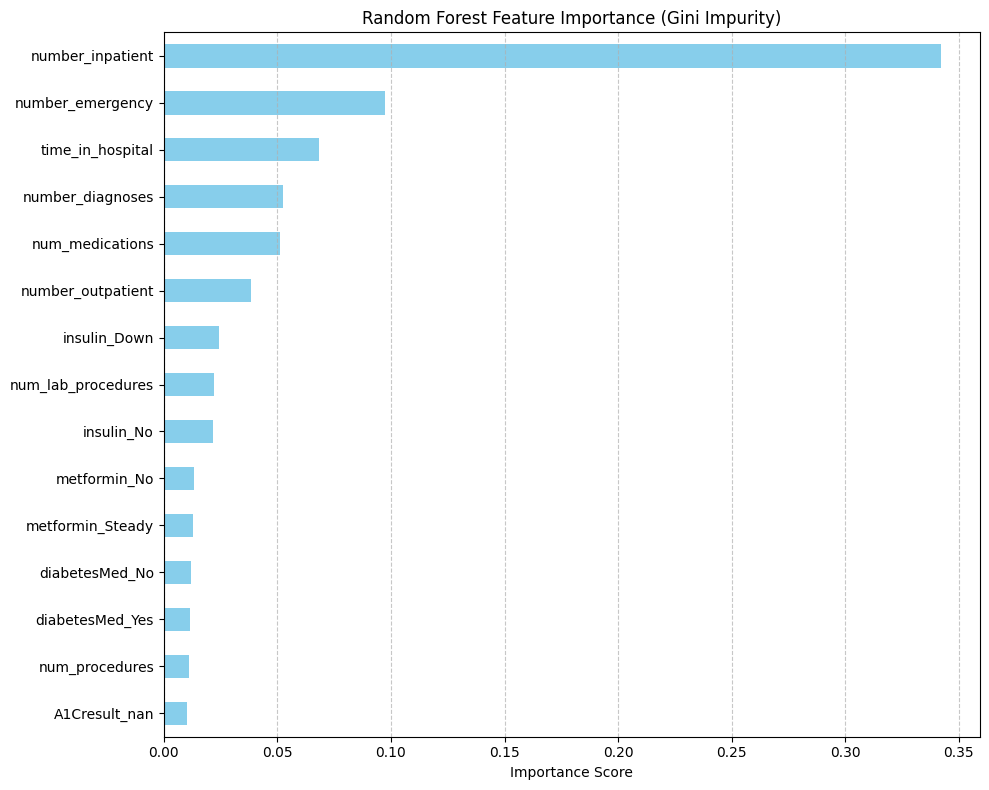

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Extract the model and feature names from the pipeline
rf_model = rf.named_steps['model']
preprocessor = rf.named_steps['preprocess']

# Get names for numerical and categorical features
feature_names_num = preprocessor.named_transformers_['num'].get_feature_names_out()
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_features = np.concatenate([feature_names_num, feature_names_cat])

# 2. Create a Pandas Series for easy plotting
importances = pd.Series(rf_model.feature_importances_, index=all_features)

# 3. Plot the Top 15 features
plt.figure(figsize=(10, 8))
importances.sort_values().tail(15).plot(kind='barh', color='skyblue')
plt.title("Random Forest Feature Importance (Gini Impurity)")
plt.xlabel("Importance Score")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Feature Importance Analysis

**Key Insight: Past Utilization Predicts Future Risk**

The Random Forest model reveals that historical healthcare utilization is the dominant driver of readmission risk, overshadowing specific clinical diagnoses or medication regimens.

* **The Dominant Predictor:** `number_inpatient` (inpatient visits in the preceding year) is the single most important feature, accounting for **~34%** of the model's total predictive power.
* **The "Frequent Flyer" Effect:** The top three features—`number_inpatient`, `number_emergency`, and `time_in_hospital`—all measure how heavily the patient interacts with the hospital system.
* **Interpretation:** The model has learned that "sickness severity" (proxied by frequent hospital visits) is a stronger predictor of readmission than the specific treatment plan (e.g., `insulin` or `metformin`).

**Actionable Takeaway:**
Intervention programs should prioritize patients based on their history of utilization. A patient with 2+ prior inpatient visits is statistically at high risk regardless of their current primary diagnosis.

### Testing with XGBoost

In [ ]:
from xgboost import XGBClassifier

# Calculate the ratio: Negatives / Positives
# 13561 / 1704 = ~7.95
ratio = 8  
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=200,       # Number of trees
        learning_rate=0.05,     # Step size shrinkage used in update to prevents overfitting
        max_depth=4,            # Depth of tree
        random_state=42,
        n_jobs=-1,              # Use all CPU cores (Much faster!)
        scale_pos_weight=ratio   # Handle class imbalance
    ))
])

xgb_pipe.fit(X_train, y_train)

# Evaluate on Validation data
print("\n=== XGBOOST: VALIDATION PERFORMANCE ===")
y_val_pred_xgb = xgb_pipe.predict(X_val)
y_val_prob_xgb = xgb_pipe.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_val, y_val_prob_xgb))
print("XGBoost PR-AUC (Average Precision):", average_precision_score(y_val, y_val_prob_xgb))



=== XGBOOST: VALIDATION PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     13561
           1       0.17      0.53      0.26      1704

    accuracy                           0.66     15265
   macro avg       0.54      0.60      0.52     15265
weighted avg       0.84      0.66      0.72     15265

XGBoost ROC-AUC: 0.6477422439659712
XGBoost PR-AUC (Average Precision): 0.20338245670786448



=== MODEL COMPARISON (Validation Set) ===
                  Model  ROC-AUC   PR-AUC  F1-Score  Precision   Recall
                XGBoost 0.647742 0.203382  0.255867   0.168529 0.531103
    Logistic Regression 0.646834 0.198926  0.258019   0.169689 0.538146
          Random Forest 0.641043 0.194003  0.253937   0.166975 0.529930
Decision Tree (depth=5) 0.634001 0.182627  0.253456   0.172334 0.478873


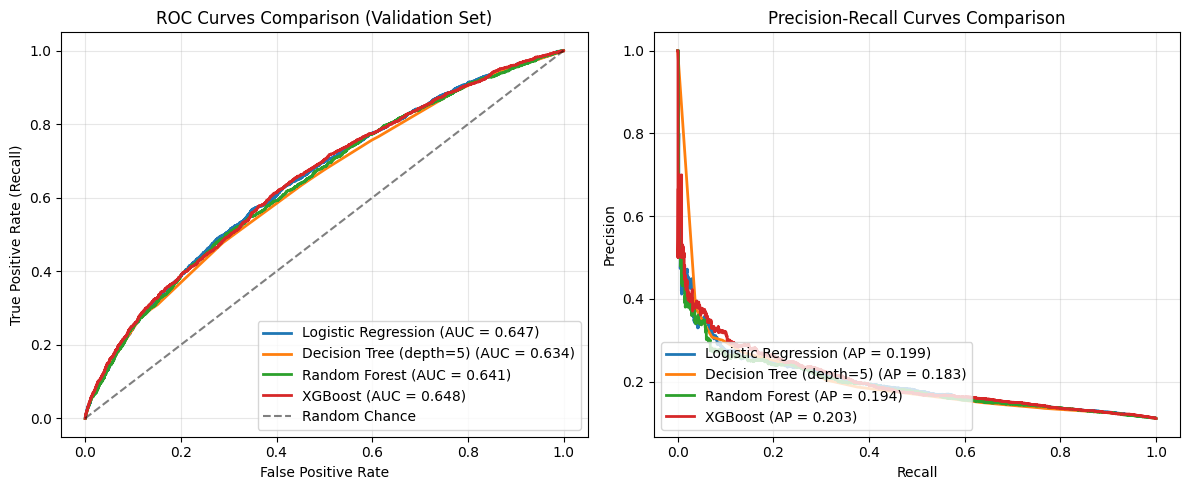

In [ ]:
# Comprehensive Model Comparison
models_dict = {
    "Logistic Regression": log_reg,
    "Decision Tree (depth=5)": tree,
    "Random Forest": rf,
    "XGBoost": xgb_pipe,
}

# Collect all model results
all_results = []
for name, model in models_dict.items():
    if hasattr(model, "predict_proba"):
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)
        
        all_results.append({
            'Model': name,
            'ROC-AUC': roc_auc_score(y_val, y_prob),
            'PR-AUC': average_precision_score(y_val, y_prob),
            'F1-Score': f1_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'y_prob': y_prob,
            'y_pred': y_pred,
            'model': model
        })

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['y_prob', 'y_pred', 'model']}
    for r in all_results
])
print("\n=== MODEL COMPARISON (Validation Set) ===")
print(comparison_df.sort_values('ROC-AUC', ascending=False).to_string(index=False))

# ROC Curves Comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for result in all_results:
    y_prob = result['y_prob']
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f"{result['Model']} (AUC = {result['ROC-AUC']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], "k--", label="Random Chance", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison (Validation Set)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Precision-Recall Curves Comparison
plt.subplot(1, 2, 2)
for result in all_results:
    y_prob = result['y_prob']
    prec, rec, _ = precision_recall_curve(y_val, y_prob)
    plt.plot(rec, prec, label=f"{result['Model']} (AP = {result['PR-AUC']:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Comparison")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Model Comparison Summary

The comparison reveals that all models achieve similar performance (ROC-AUC ~0.64-0.65), suggesting either:
1. The problem is inherently challenging with the available features
2. Models are hitting a performance ceiling with current feature engineering
3. Potential remaining data leakage or feature interactions not captured

Key observations:
- **Similar Performance**: All models cluster around ROC-AUC of 0.64-0.65, indicating limited differentiation
- **PR-AUC**: Lower values reflect the class imbalance challenge
- **Recall-Precision Tradeoff**: Models struggle to balance high recall with acceptable precision
- **Feature Utilization**: Historical utilization metrics dominate feature importance

This suggests that while ensemble methods reduce variance and overfitting compared to single trees, the fundamental predictive signal may be limited by the data itself.


### Confusion Matrices Visualization


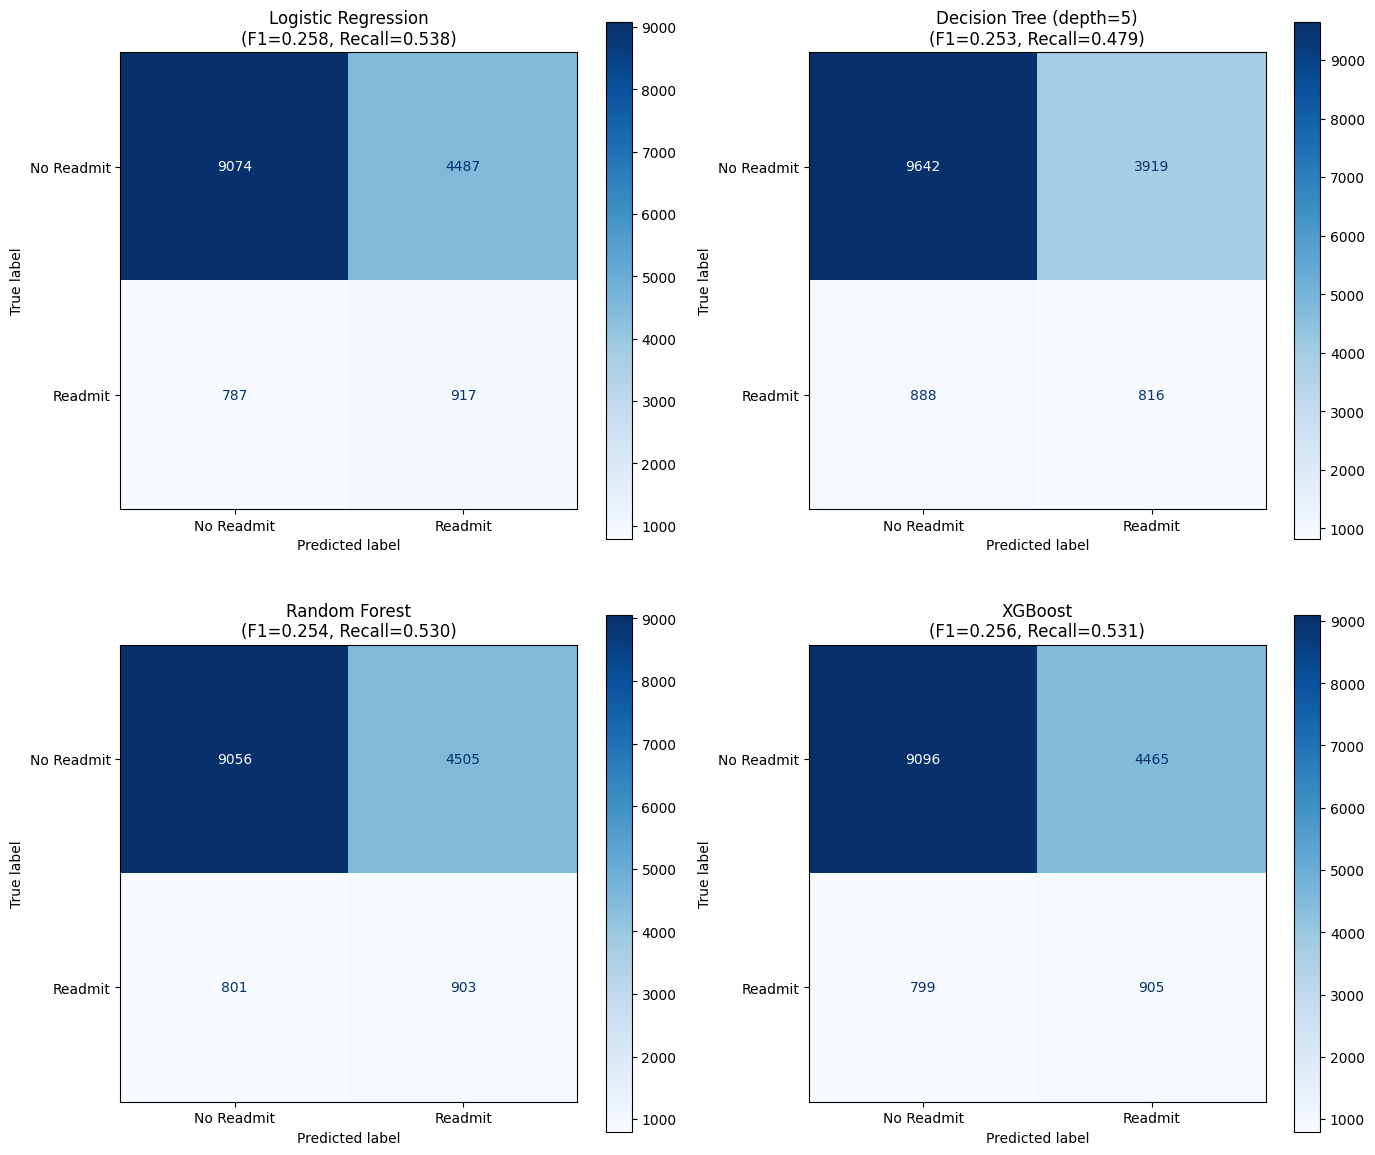

In [ ]:
# Visualize confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, result in enumerate(all_results):
    cm = confusion_matrix(y_val, result['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=['No Readmit', 'Readmit'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f"{result['Model']}\n(F1={result['F1-Score']:.3f}, Recall={result['Recall']:.3f})")

plt.tight_layout()
plt.show()


### Hyperparameter Tuning with Cross-Validation


In [98]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [3, 5, 7, None],
    'model__min_samples_leaf': [1, 3, 5, 10],
    'model__max_features': ['sqrt', 'log2', 0.5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_search = RandomizedSearchCV(
    rf,
    rf_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_iter=10,  # Number of parameter settings sampled
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting RandomizedSearchCV for Random Forest...")
rf_search.fit(X_train, y_train)

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best CV score (ROC-AUC): {rf_search.best_score_:.4f}")

# Evaluate best model
best_rf = rf_search.best_estimator_
print("\n=== Best Random Forest on Validation Set ===")
best_rf_results = eval_model(best_rf, X_train, y_train, X_val, y_val, "Best RF", return_metrics=True)


Starting RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END model__max_depth=3, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=300; total time=   3.7s
[CV] END model__max_depth=3, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=300; total time=   3.9s
[CV] END model__max_depth=3, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=300; total time=   4.4s
[CV] END model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=300; total time=  10.2s
[CV] END model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=300; total time=  10.5s
[CV] END model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=300; total time=  11.4s
[CV] END model__max_depth=5, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=400; total time=   9.4s
[CV] 

### Cross-Validation Evaluation


=== Cross-Validation Results (5-fold, ROC-AUC) ===

Logistic Regression:
  Mean ROC-AUC: 0.6333 (+/- 0.0144)
  Individual folds: [0.63109228 0.64076935 0.62035317 0.63588782 0.63818435]
Random Forest (Tuned):
  Mean ROC-AUC: 0.6392 (+/- 0.0159)
  Individual folds: [0.64062104 0.64338221 0.62349211 0.64441682 0.6439861 ]
XGBoost:
  Mean ROC-AUC: 0.6353 (+/- 0.0131)
  Individual folds: [0.63595571 0.63869679 0.62245731 0.63994598 0.63929518]


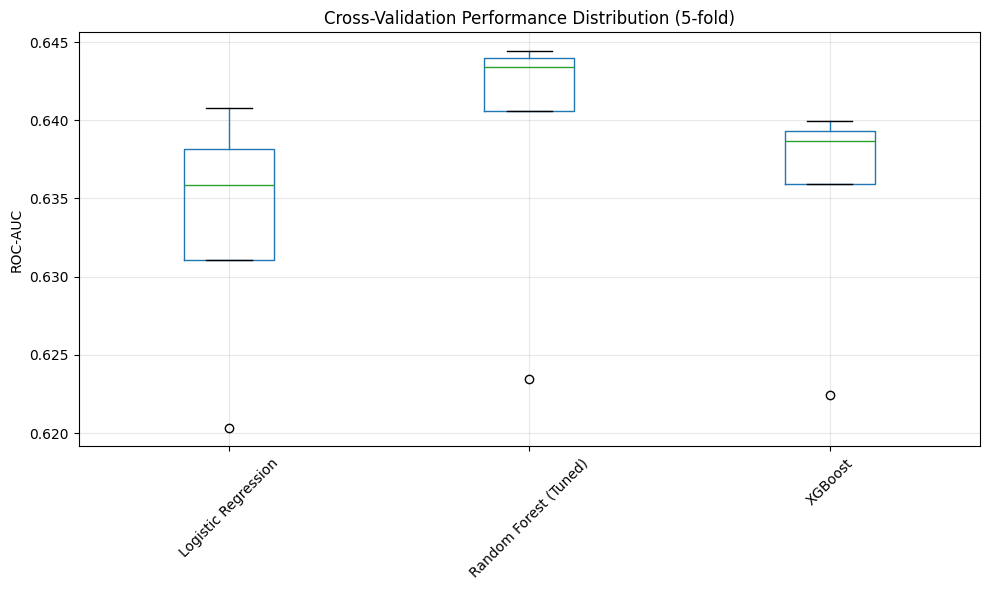

In [99]:
from sklearn.model_selection import cross_val_score

# Cross-validation evaluation for selected models
cv_models = {
    "Logistic Regression": log_reg,
    "Random Forest (Tuned)": best_rf if 'best_rf' in locals() else rf,
    "XGBoost": xgb_pipe,
}

print("=== Cross-Validation Results (5-fold, ROC-AUC) ===\n")
cv_results = {}
for name, model in cv_models.items():
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )
    cv_results[name] = cv_scores
    print(f"{name}:")
    print(f"  Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Individual folds: {cv_scores}")

# Visualize CV results
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
cv_df.boxplot()
plt.ylabel('ROC-AUC')
plt.title('Cross-Validation Performance Distribution (5-fold)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Final Model Selection and Test Set Evaluation

**Important**: The test set should only be evaluated once, after selecting the final model based on validation performance.


Selected Final Model: Random Forest (Tuned)

FINAL TEST SET EVALUATION (One-time use)

=== Random Forest (Tuned): TEST SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     13562
           1       0.19      0.30      0.23      1703

    accuracy                           0.78     15265
   macro avg       0.55      0.57      0.55     15265
weighted avg       0.82      0.78      0.80     15265


Test Set Metrics:
  ROC-AUC: 0.6363
  PR-AUC: 0.1877
  F1-Score: 0.2305
  Precision: 0.1890
  Recall: 0.2954


<Figure size 800x600 with 0 Axes>

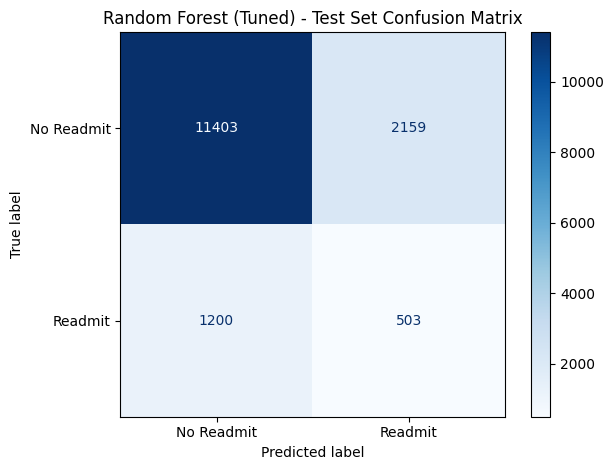

In [100]:
# Select best model based on validation performance
# For this analysis, we'll use the best Random Forest if tuned, otherwise use XGBoost
if 'best_rf' in locals():
    final_model = best_rf
    final_model_name = "Random Forest (Tuned)"
else:
    # Use XGBoost as it had the best ROC-AUC
    final_model = xgb_pipe
    final_model_name = "XGBoost"

print(f"Selected Final Model: {final_model_name}")
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION (One-time use)")
print("="*60)

# Retrain on full training set (train + validation combined)
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_model.fit(X_train_full, y_train_full)

# Evaluate on test set
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

print(f"\n=== {final_model_name}: TEST SET PERFORMANCE ===")
print(classification_report(y_test, y_test_pred))

test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_pr_auc = average_precision_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"\nTest Set Metrics:")
print(f"  ROC-AUC: {test_roc_auc:.4f}")
print(f"  PR-AUC: {test_pr_auc:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")

# Test set confusion matrix
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=['No Readmit', 'Readmit'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'{final_model_name} - Test Set Confusion Matrix')
plt.tight_layout()
plt.show()


### Summary and Conclusions

**Key Findings:**
1. **Model Performance**: All models achieve similar ROC-AUC scores (~0.64-0.65), suggesting the problem is inherently challenging or feature-limited
2. **Class Imbalance**: The 11% positive class rate makes achieving high recall with good precision difficult
3. **Feature Insights**: Historical utilization (number_inpatient) is the strongest predictor, accounting for ~34% of feature importance
4. **Model Selection**: Ensemble methods (Random Forest, XGBoost) provide better generalization than single trees, but performance gains are modest

**Recommendations for Future Work:**
1. **Feature Engineering**: Create interaction features, temporal features, or domain-specific transformations
2. **External Data**: Incorporate socioeconomic factors, post-discharge follow-up data, or medication adherence metrics
3. **Ensemble Methods**: Try stacking or voting ensembles of the best-performing models
4. **Cost-Sensitive Learning**: Incorporate actual costs of false negatives vs false positives
5. **Threshold Optimization**: Use domain expertise to determine optimal recall-precision tradeoff based on intervention capacity
